This document contains code for splitting the raw merged data into train, validation, and test sets. 

1. Use iterative thresholding 

2. Optionally use correlation based imputation

3. split into train, validation, and test sets. 
- For each income level (high, upper middle, lower middle, and low), split the data into 80% train, 10% validation, 10% test
- The same country should only be present in one of the train, validate, test sets to have independence of the sets 

- OR, if splitting by year, split by percentage of data, with independence between sets guaranteed by splitting years between sets
- Same 80 : 10 : 10 split 


In [250]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.decomposition as sk
import copy
import numpy as np
from sklearn.model_selection import GroupKFold

In [416]:
merged = pd.DataFrame(pd.read_pickle('../raw_merged_data_v2_withinyears'))

In [417]:
missing_dropped = merged.dropna(axis=1, how='all', ignore_index=True)

In [418]:
dropped = missing_dropped.drop(['Lifetime risk of maternal death (1 in: rate varies by country)', 'Lifetime risk of maternal death (%)', 'Number of maternal deaths'], axis=1)

### Exploring Merged Data

In [419]:
dropped

,date,Women and girls who use menstrual materials (% of women and girls ages 15-49 who had a menstrual period within the last year),setting,"Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions, ages 5-14 (% of population ages 5-14)","Mortality rate attributed to household and ambient air pollution, age-standardized, female (per 100,000 female population)","Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions, ages 0-4 (% of population ages 0-4)","Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions, ages 60+ (% of population ages 60+)",Women participating in own health care decisions (% of women age 15-49),Antiretroviral therapy coverage (% of adult males living with HIV),"Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions, ages 60+, male (% of male population ages 60+)",...,Land area where elevation is below 5 meters (% of total land area) urban,Population living in areas where elevation is below 5 meters (% of total population) rural,Population living in areas where elevation is below 5 meters (% of total population) urban,Coverage of social safety net programs (% of population) Quintile 1 (poorest),Coverage of social safety net programs (% of population) Quintile 5 (richest),Coverage of social insurance programs (% of population) Quintile 1 (poorest),Coverage of social insurance programs (% of population) Quintile 5 (richest),Coverage of unemployment benefits and ALMP (% of population) Quintile 1 (poorest),Coverage of unemployment benefits and ALMP (% of population) Quintile 5 (richest),income_num
0,2019.0,94.52,Algeria,16.054,45.0,71.605,3.918,NaN,61.0,3.911,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
1,2015.0,NaN,Algeria,18.055,NaN,70.700,4.082,NaN,43.0,4.081,...,0.007108,0.120913,1.124755,NaN,NaN,NaN,NaN,NaN,NaN,3.0
2,2010.0,NaN,Algeria,17.537,NaN,72.403,4.115,NaN,21.0,4.153,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
3,2000.0,NaN,Algeria,20.944,NaN,77.248,4.371,NaN,7.0,4.454,...,0.006448,0.165027,1.217309,NaN,NaN,NaN,NaN,NaN,NaN,3.0
4,2020.0,NaN,Algeria,NaN,NaN,NaN,NaN,NaN,62.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9545,2000.0,NaN,NIU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
9546,2005.0,NaN,NIU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
9547,2010.0,NaN,NIU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
9548,2015.0,NaN,NIU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [420]:
ydrop = dropped.dropna(how = 'all', subset=['Maternal mortality ratio (modeled estimate, per 100,000 live births)', 'Maternal mortality ratio (national estimate, per 100,000 live births)'])
ydrop

,date,Women and girls who use menstrual materials (% of women and girls ages 15-49 who had a menstrual period within the last year),setting,"Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions, ages 5-14 (% of population ages 5-14)","Mortality rate attributed to household and ambient air pollution, age-standardized, female (per 100,000 female population)","Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions, ages 0-4 (% of population ages 0-4)","Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions, ages 60+ (% of population ages 60+)",Women participating in own health care decisions (% of women age 15-49),Antiretroviral therapy coverage (% of adult males living with HIV),"Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions, ages 60+, male (% of male population ages 60+)",...,Land area where elevation is below 5 meters (% of total land area) urban,Population living in areas where elevation is below 5 meters (% of total population) rural,Population living in areas where elevation is below 5 meters (% of total population) urban,Coverage of social safety net programs (% of population) Quintile 1 (poorest),Coverage of social safety net programs (% of population) Quintile 5 (richest),Coverage of social insurance programs (% of population) Quintile 1 (poorest),Coverage of social insurance programs (% of population) Quintile 5 (richest),Coverage of unemployment benefits and ALMP (% of population) Quintile 1 (poorest),Coverage of unemployment benefits and ALMP (% of population) Quintile 5 (richest),income_num
0,2019.0,94.52,Algeria,16.054,45.0,71.605,3.918,NaN,61.0,3.911,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
1,2015.0,NaN,Algeria,18.055,NaN,70.700,4.082,NaN,43.0,4.081,...,0.007108,0.120913,1.124755,NaN,NaN,NaN,NaN,NaN,NaN,3.0
2,2010.0,NaN,Algeria,17.537,NaN,72.403,4.115,NaN,21.0,4.153,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
3,2000.0,NaN,Algeria,20.944,NaN,77.248,4.371,NaN,7.0,4.454,...,0.006448,0.165027,1.217309,NaN,NaN,NaN,NaN,NaN,NaN,3.0
4,2020.0,NaN,Algeria,NaN,NaN,NaN,NaN,NaN,62.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8851,1989.0,NaN,Puerto Rico,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
8852,1988.0,NaN,Puerto Rico,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
8853,1987.0,NaN,Puerto Rico,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
8854,1986.0,NaN,Puerto Rico,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0


In [422]:
dropped_countries = dropped['setting'].unique()
ydrop_countries = ydrop['setting'].unique()

for d in dropped_countries:
    if d not in ydrop_countries:
        print(d)

Turks and Caicos Islands
Kosovo
British Virgin Islands
Hong Kong SAR, China
American Samoa
Aruba
Bermuda
Cayman Islands
Channel Islands
Curacao
Faroe Islands
French Polynesia
Gibraltar
Greenland
Guam
Isle of Man
Liechtenstein
Macao SAR, China
New Caledonia
Northern Mariana Islands
Sint Maarten (Dutch part)
St. Martin (French part)
Virgin Islands (U.S.)
COK
NIU


In [376]:
len(dropped['setting'].unique())

294

#### MMR Exploration

Text(0, 0.5, 'Number of Samples')

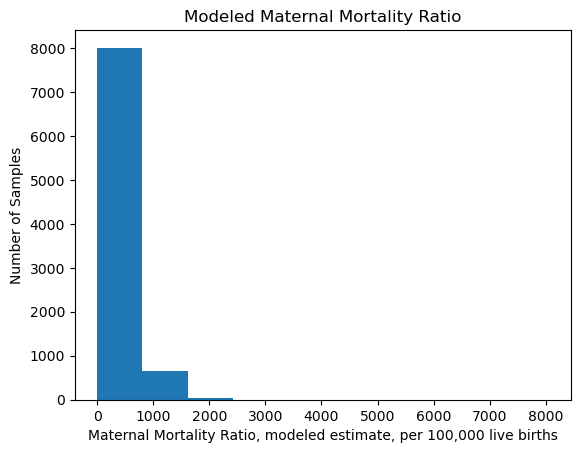

In [446]:
mmr_modeled = dropped['Maternal mortality ratio (modeled estimate, per 100,000 live births)']
plt.hist(mmr_modeled, label='national estimate')
plt.title('Modeled Maternal Mortality Ratio')
plt.xlabel('Maternal Mortality Ratio, modeled estimate, per 100,000 live births')
plt.ylabel('Number of Samples')

Text(0, 0.5, 'Number of Samples')

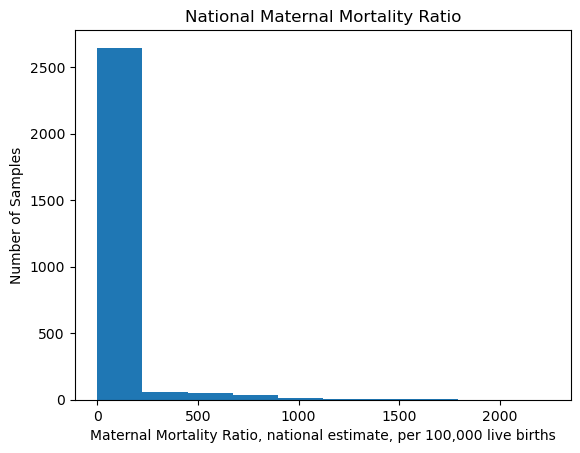

In [445]:
mmr_national = dropped['Maternal mortality ratio (national estimate, per 100,000 live births)']
plt.hist(mmr_national, label='national estimate')
plt.title('National Maternal Mortality Ratio')
plt.xlabel('Maternal Mortality Ratio, national estimate, per 100,000 live births')
plt.ylabel('Number of Samples')

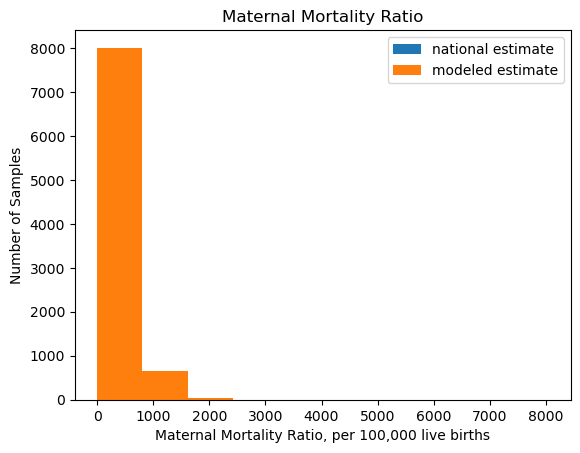

In [447]:
plt.hist(mmr_national, label='national estimate')

plt.hist(mmr_modeled, label='modeled estimate')
plt.title('Maternal Mortality Ratio')
plt.xlabel('Maternal Mortality Ratio, per 100,000 live births')
plt.ylabel('Number of Samples')

plt.legend()

In [565]:
print('modelled MMR mean', np.nanmedian(mmr_modeled))
print('national MMR mean', np.nanmedian(mmr_national))
print('modelled MMR std', np.std(mmr_modeled))
print('national MMR std', np.std(mmr_national))

modelled MMR mean 86.0
national MMR mean 19.0
modelled MMR std 395.65909413079146
national MMR std 165.172675853656


## Iterative Thresholding 

### Code

In [462]:
def drop_col(dataset, threshold):
    #excluding columns with greater than the threshold of NAN values 
    to_drop = []
    for col in range(0, dataset.shape[1]):
        proportion = (dataset.iloc[:,col].isnull().sum())/(dataset.shape[0])
        if proportion > threshold:
            to_drop.append(dataset.columns[col])

    colthresh = dataset.drop(to_drop, axis=1)

    colthresh = colthresh.reset_index(drop=True)

    return colthresh

In [463]:
def drop_row(dataset, threshold):
    
    #excluding rows with greater than the threshold of NAN values 
    to_drop = []
    for row in range(1, dataset.shape[0]):
        proportion = (dataset.iloc[row, :].isnull().sum())/(dataset.shape[1])
        if proportion > threshold:
            to_drop.append(row)
    
    rowthresh = dataset.drop(to_drop, axis=0, inplace=False)
    rowthresh = rowthresh.reset_index(drop=True)
    
    return rowthresh

In [464]:
def total_nan_proportion(dataset):
    total_nan = dataset.isnull().sum().sum()
    total = dataset.shape[0] * dataset.shape[1]
    proportion_total = total_nan/total 
    return proportion_total

In [465]:
def iterative_thresholding(dataset_to_threshold, threshold):
    last_proportion = total_nan_proportion(dataset_to_threshold)
    keep_going = True
    dataset_copy = copy.deepcopy(dataset_to_threshold.reset_index())
    changes = []

    while keep_going == True:

        dataset_copy = drop_row(dataset_copy, threshold)
        dataset_copy = drop_col(dataset_copy, threshold)
        
        
        current_proportion = total_nan_proportion(dataset_copy)
        
        #to determine whether dropping the rows and/or columns has caused other rows/columns to breach the threshold
        breached = False
        for col in range(0, dataset_copy.shape[1]):
            proportion = (dataset_copy.iloc[:,col].isnull().sum())/(dataset_copy.shape[0])
            if proportion > threshold:
                breached = True
        for row in range(1, dataset_copy.shape[0]):
            proportion = (dataset_copy.iloc[row, :].isnull().sum())/(dataset_copy.shape[1])
            if proportion > threshold:
                breached = True
        
        if breached == False:
            keep_going = False
        else: 
            changes.append(current_proportion-last_proportion)
            last_proportion = current_proportion 

    return dataset_copy, current_proportion, changes


In [466]:
testing_thresholds = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]

proportion_remaining = []
rows_remaining = []
columns_remaining = []
threshold_datasets = []

for test in testing_thresholds:
    new_data, new_proportion, new_changes = iterative_thresholding(ydrop, test)
    proportion_remaining.append(new_proportion)
    rows_remaining.append(new_data.shape[0])
    columns_remaining.append(new_data.shape[1])
    threshold_datasets.append(new_data)

In [467]:
threshold_95 = threshold_datasets[-2]
threshold_95 = threshold_95.drop('index', axis=1)
threshold_100 = threshold_datasets[-1]
threshold_100 = threshold_100.drop('index', axis=1)

In [468]:
iterative_thresholded_data = [threshold_95, threshold_100]

### Visualisation

In [430]:
proportion_remaining

[0.04671637680018887,
 0.050384645423305216,
 0.06856706685011026,
 0.08490165972069898,
 0.09308629514815082,
 0.11398786635905324,
 0.35171749967675664,
 0.5900609433986574,
 0.6846949694400615,
 0.7606822368421052,
 0.8342852436238102]

In [431]:
rows_remaining

[970, 970, 970, 970, 970, 987, 1481, 3155, 4931, 7296, 9550]

In [432]:
columns_remaining

[524, 528, 547, 564, 572, 581, 611, 615, 615, 625, 731]

Text(0, 0.5, 'Number of Columns Remaining')

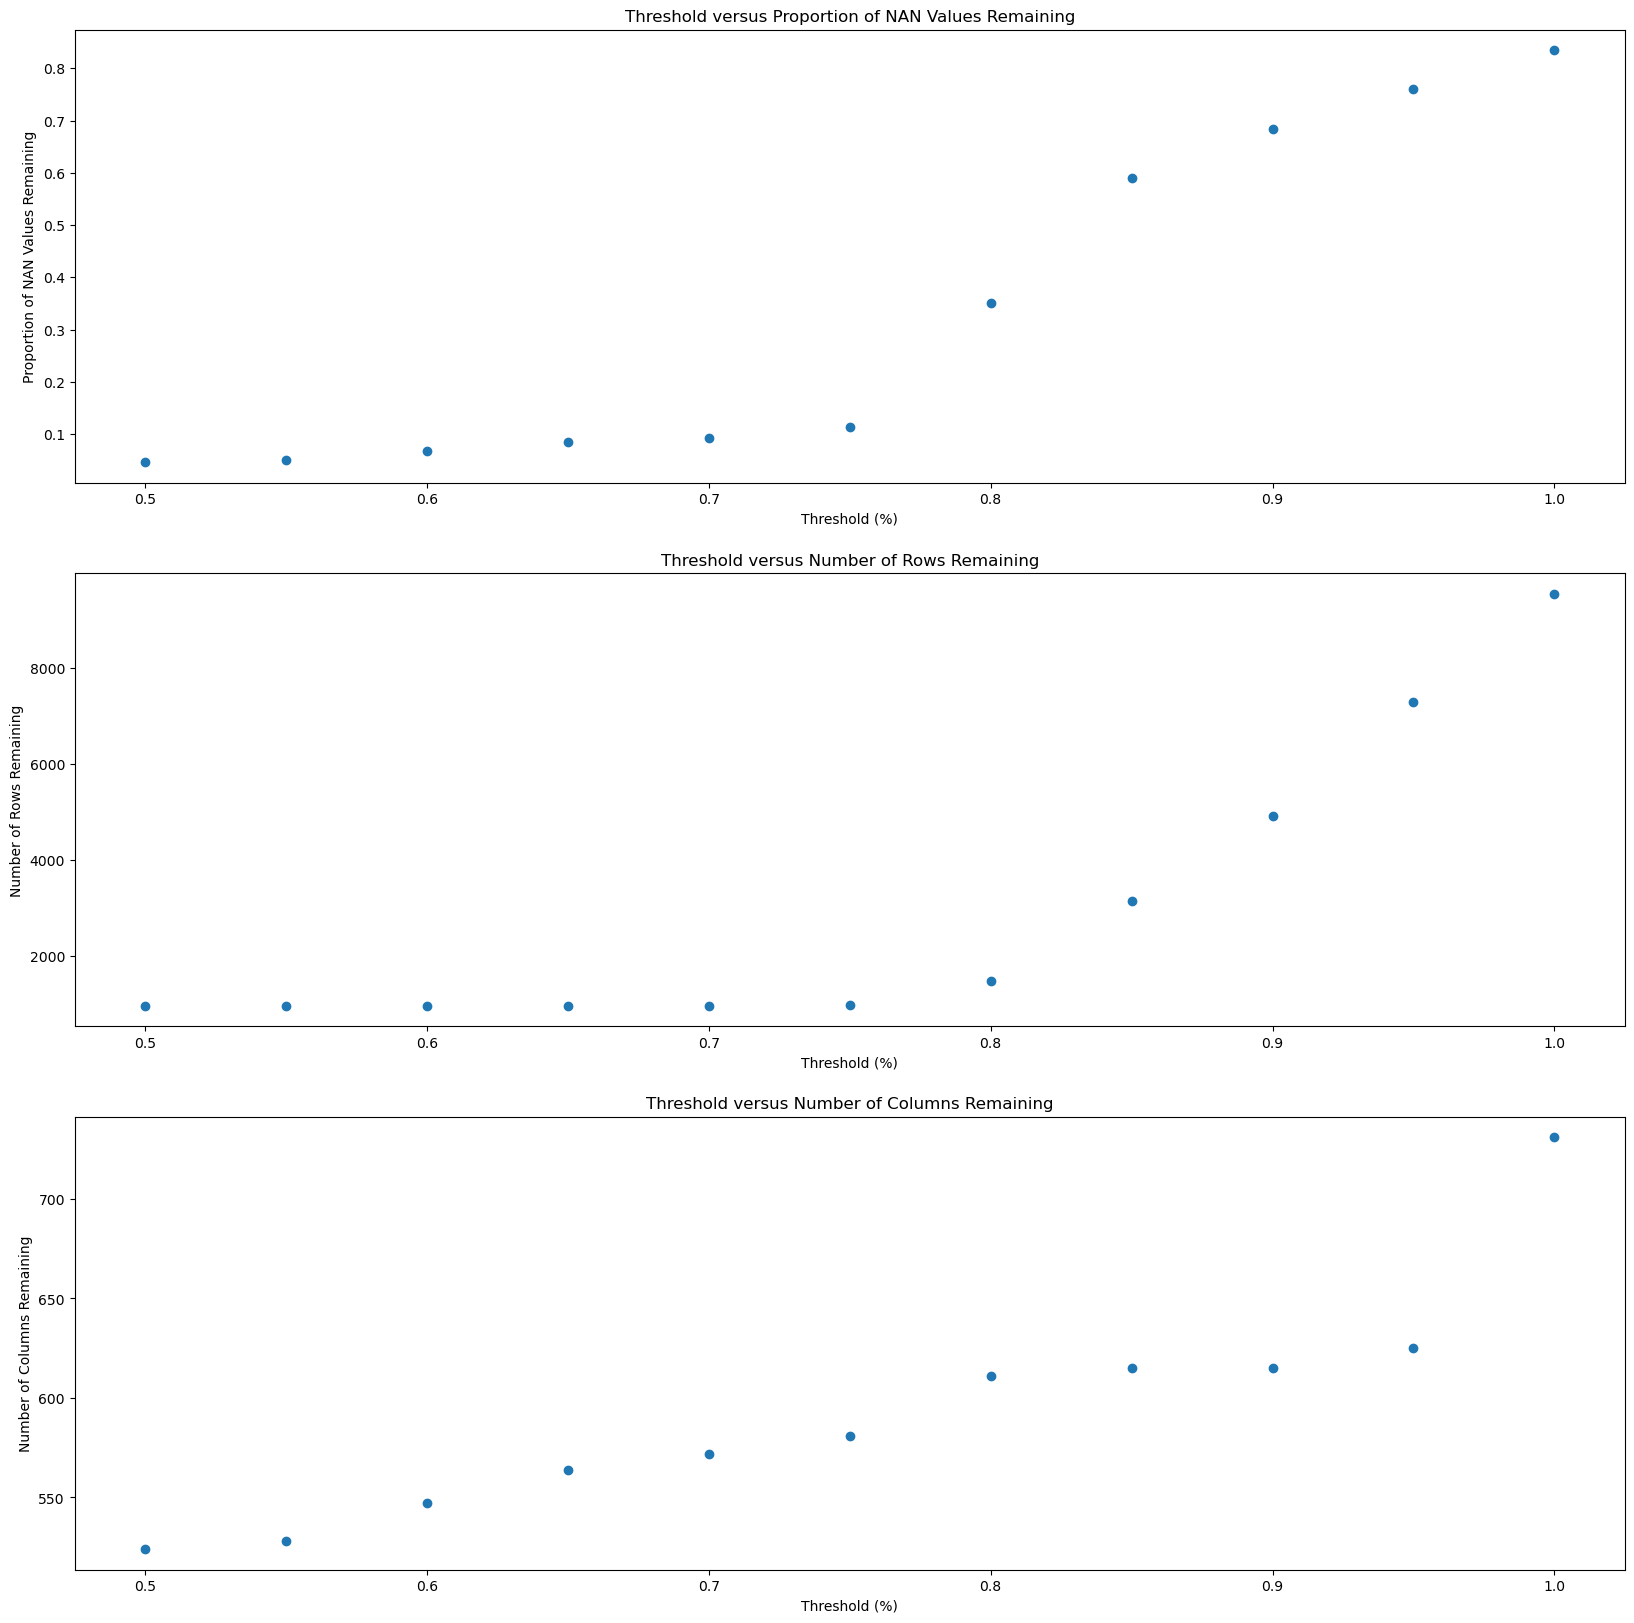

In [433]:
_, axes = plt.subplots(3, 1, figsize=(20, 20))

axes[0].scatter(testing_thresholds, proportion_remaining)
axes[0].set_title('Threshold versus Proportion of NAN Values Remaining')
axes[0].set_xlabel('Threshold (%)')
axes[0].set_ylabel('Proportion of NAN Values Remaining')

axes[1].scatter(testing_thresholds, rows_remaining)
axes[1].set_title('Threshold versus Number of Rows Remaining')
axes[1].set_xlabel('Threshold (%)')
axes[1].set_ylabel('Number of Rows Remaining')

axes[2].scatter(testing_thresholds, columns_remaining)
axes[2].set_title('Threshold versus Number of Columns Remaining')
axes[2].set_xlabel('Threshold (%)')
axes[2].set_ylabel('Number of Columns Remaining')

## Correlation Based Imputation

1. Estimate the correlation between different columns 
2. In order of decreasing correlation, look for columns with the largest differences in number of imputed values
3. impute the values  

The pearson correlation coefficient used here to determine the strength of relationship. It is based on linear correlation.
Thus, will take an estimate with > 80% correlation and < 30% missing values
- will fit np's polyfit(degree=1) on this column and use to predict missing values of other column

In [469]:
def correlation_matching(col_to_match, dataset):
    best_corr = 0
    best_index = None
    #starting from index 4 to exclude setting, date, dimension and subgroup features because they are not numeric 
    for col in range(4, dataset.shape[1]):
        #necessary as self-correlation will be 1.0
        if col == col_to_match:
            continue
        if dataset.columns[col] == 'Maternal mortality ratio (modeled estimate, per 100,000 live births)':
            continue
        if dataset.columns[col] == 'Maternal mortality ratio (national estimate, per 100,000 live births)':
            continue
        #want any column chosen as basis of computation to have less than 50% missing values 
        if dataset.iloc[:, col].isna().mean() > 0.5:
            continue
        col_compare = dataset[[dataset.columns[col_to_match], dataset.columns[col]]]
        correlation = abs(col_compare.corr(min_periods=50).iloc[0, 1])
        if correlation > best_corr:
            best_corr = correlation
            best_index = col
    return best_corr, best_index

In [470]:
def correlation_imputing(dataset):
    dataset_copy = dataset.copy()
    #do not need to impute the setting, date, dimension and subgroup features 
    for feature in range(4, dataset.shape[1]):

        if dataset.columns[feature] == 'Maternal mortality ratio (modeled estimate, per 100,000 live births)':
            continue
        if dataset.columns[feature] == 'Maternal mortality ratio (national estimate, per 100,000 live births)':
            continue

        #only want to impute columns with sufficient missing data that they would struggle imputing from themselves. 
        if dataset.iloc[:, feature].isna().mean() > 0.75:
            best_corr, best_index = correlation_matching(feature, dataset)

            #only want to perform correlation matching if correlation is sufficiently strong:
            if best_corr > 0.90:
                feature_to_use = dataset_copy.iloc[:, best_index].copy()

                non_nan_indices = feature_to_use.dropna().index
                non_nan_values = feature_to_use.dropna().values

                coefficients = np.polyfit(non_nan_indices, non_nan_values, 1)
                poly = np.poly1d(coefficients)
                extrapolated_values = poly(dataset_copy.iloc[:, feature].index)
                dataset_copy.iloc[:, feature] = dataset_copy.iloc[:, feature].where(dataset_copy.iloc[:, feature].notna(), extrapolated_values)
    
    return dataset_copy

In [471]:
proportion_95_uncorrelated = total_nan_proportion(threshold_95)
print('proportion_95_uncorrelated', proportion_95_uncorrelated)
proportion_100_uncorrelated = total_nan_proportion(threshold_100)
print('proportion_100_uncorrelated', proportion_100_uncorrelated)

proportion_95_uncorrelated 0.762380550129349
proportion_100_uncorrelated 0.8214574134873014


In [472]:
correlated_95 = correlation_imputing(threshold_95)
correlated_100 = correlation_imputing(threshold_100)

In [473]:
proportion_95_corr = total_nan_proportion(correlated_95)
print('proportion_95', proportion_95_corr)
proportion_100_corr = total_nan_proportion(correlated_100)
print('proportion_100', proportion_100_corr)

proportion_95 0.736874373053165
proportion_100 0.7925494043800395


In [474]:
correlated_datasets = [correlated_95, correlated_100]

## Splitting Data

### Splitting by Income Level and Country

In [475]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()

In [476]:
hinc_cutoff = {'95_uncorr' : 0, '100_uncorr' : 0, '95_corr' : 0, '100_corr' : 0}
um_cutoff = {'95_uncorr' : 0, '100_uncorr' : 0, '95_corr' : 0, '100_corr' : 0}
lm_cutoff = {'95_uncorr' : 0, '100_uncorr' : 0, '95_corr' : 0, '100_corr' : 0}
linc_cutoff = {'95_uncorr' : 0, '100_uncorr' : 0, '95_corr' : 0, '100_corr' : 0}

#### Function Design and Testing:

In [477]:
t = correlated_datasets[0]

t['date'] = t['date'].astype(str)

#high income 
hinc = t[t['income_num'] == 4]

#to get de-duplicated list of high income countries
hinc_countries = hinc['setting'].unique()

#shuffles the countries to prevent any biased ordering (alphabetical)
np.random.shuffle(hinc_countries)

hinc_countries

array(['Belgium', 'Monaco', 'Israel', 'Hungary', 'Bahamas, The',
       'Andorra', 'United States', 'San Marino', 'New Zealand', 'Qatar',
       'Chile', 'Antigua and Barbuda', 'Brunei Darussalam', 'Guyana',
       'Palau', 'Germany', 'Malta', 'United Kingdom', 'Canada', 'Croatia',
       'Australia', 'Bulgaria', 'Poland', 'Lithuania', 'Austria',
       'Russian Federation', 'Korea, Rep.', 'Czechia',
       'St. Kitts and Nevis', 'Norway', 'France', 'Italy', 'Japan',
       'Iceland', 'Barbados', 'Spain', 'Slovenia', 'Denmark', 'Finland',
       'Portugal', 'Ireland', 'Kuwait', 'Romania', 'Slovak Republic',
       'Trinidad and Tobago', 'Estonia', 'Puerto Rico', 'Uruguay',
       'Latvia', 'Bahrain', 'Panama', 'United Arab Emirates', 'Singapore',
       'Nauru', 'Greece', 'Saudi Arabia', 'Oman', 'Switzerland', 'Cyprus',
       'Seychelles', 'Sweden', 'Netherlands', 'Luxembourg'], dtype=object)

In [478]:
#80% of countries to the train set, then the next 10% to the validation set
hinc_cutoff['train_95_corr'] = len(hinc) * 0.8
hinc_cutoff['val_95_corr'] = len(hinc) * 0.9

In [479]:
hinc_cutoff

{'95_uncorr': 0,
 '100_uncorr': 0,
 '95_corr': 0,
 '100_corr': 0,
 'train_95_corr': 1600.0,
 'val_95_corr': 1800.0}

In [480]:
hinc_country_rownum = hinc['setting'].value_counts().loc[hinc_countries]

hinc_cumulative_num = hinc_country_rownum.cumsum()

hinc_cumulative_num

setting
Belgium           35
Monaco            42
Israel            72
Hungary          108
Bahamas, The     139
                ... 
Cyprus          1863
Seychelles      1896
Sweden          1930
Netherlands     1966
Luxembourg      2000
Name: count, Length: 63, dtype: int64

In [481]:
train_countries = []
val_countries = []
test_countries = []

for country, cumulative in zip(hinc_countries, hinc_cumulative_num):
    if cumulative <= hinc_cutoff['train_95_corr']:
        train_countries.append(country)
    elif cumulative <= hinc_cutoff['val_95_corr']:
        val_countries.append(country)
    else:
        test_countries.append(country)

In [482]:
test_countries

['Switzerland', 'Cyprus', 'Seychelles', 'Sweden', 'Netherlands', 'Luxembourg']

In [483]:
val_countries

['Panama',
 'United Arab Emirates',
 'Singapore',
 'Nauru',
 'Greece',
 'Saudi Arabia',
 'Oman']

In [484]:
train_df = t[t['setting'].isin(train_countries)]
val_df = t[t['setting'].isin(val_countries)]
test_df = t[t['setting'].isin(test_countries)]

In [485]:
val_df

,date,setting,"Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions, ages 5-14 (% of population ages 5-14)","Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions, ages 0-4 (% of population ages 0-4)","Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions, ages 60+ (% of population ages 60+)",Antiretroviral therapy coverage (% of adult males living with HIV),"Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions, ages 60+, male (% of male population ages 60+)","Mortality rate, infant (per 1,000 live births)","Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions, ages 15-59 (% of population ages 15-59)","Cause of death, by injury, ages 15-59, female (% of female population ages 15-59)",...,Trained teachers in primary education (% of total teachers) male,Land area where elevation is below 5 meters (% of total land area) rural,Land area where elevation is below 5 meters (% of total land area) urban,Population living in areas where elevation is below 5 meters (% of total population) rural,Population living in areas where elevation is below 5 meters (% of total population) urban,Coverage of social safety net programs (% of population) Quintile 1 (poorest),Coverage of social safety net programs (% of population) Quintile 5 (richest),Coverage of social insurance programs (% of population) Quintile 1 (poorest),Coverage of social insurance programs (% of population) Quintile 5 (richest),income_num
4252,2019.0,Greece,4.434,54.168,13.578,69.0,10.842,3.5,3.754000,7.786,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
4253,2015.0,Greece,4.069,45.098,10.421,56.0,8.781,3.6,3.118000,9.165,...,NaN,3.255557,0.159130,2.240929,2.867271,NaN,NaN,NaN,NaN,4.0
4254,2010.0,Greece,5.162,38.587,5.872,43.0,5.641,3.3,3.137000,9.092,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
4255,2000.0,Greece,8.602,49.697,3.834,43.0,3.801,5.5,2.040000,14.297,...,NaN,3.253682,0.161004,2.220322,2.888547,NaN,NaN,NaN,NaN,4.0
4256,2020.0,Greece,NaN,NaN,NaN,70.0,NaN,3.4,75.198461,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7171,2004.0,Nauru,NaN,NaN,NaN,NaN,NaN,31.5,80.530482,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
7172,2003.0,Nauru,NaN,NaN,NaN,NaN,NaN,31.9,80.532311,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
7173,2002.0,Nauru,NaN,NaN,NaN,NaN,NaN,32.5,80.534140,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
7174,2001.0,Nauru,NaN,NaN,NaN,NaN,NaN,33.3,80.535969,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0


In [486]:
print(f"Train: {len(train_df)/len(hinc):.2%}")
print(f"Validation: {len(val_df)/len(hinc):.2%}")
print(f"Test: {len(test_df)/len(hinc):.2%}")

Train: 78.25%
Validation: 11.30%
Test: 10.45%


### Function Formulation

#### Main Function

In [487]:
income_levels = ['linc', 'lm', 'um', 'hinc']

In [488]:
import random
# Set a seed for reproducibility
random.seed(42)

In [489]:
def split_by_inc(df, corr, prop):

    df['date'] = df['date'].astype(str)

    tv = []
    test = []

    for idx, inc in enumerate(income_levels):

        level = idx + 1 #increment by 1 because count starts from zero 
        
        #getting all countries with the index level 
        inc_countries = df[df['income_num'] == level]

        #to get de-duplicated list of high income countries and shuffle the countries to prevent any biased ordering (alphabetical)
        countries = inc_countries['setting'].unique()
        random.shuffle(countries)

        #90% of countries to the train/val set, then the next 10% to the test set
        cutoff = None
        if level == 1:
            cutoff = linc_cutoff
        elif level == 2:
            cutoff = lm_cutoff
        elif level == 3:
            cutoff = um_cutoff
        elif level == 4:
            cutoff = hinc_cutoff
        
        if corr == True:
            name = str(prop) + '_corr'
        else:
            name =  str(prop) + '_uncorr'

        cutoff[name] = len(inc_countries) * 0.9

        #to get the number of rows taken up by each country, and then get cumulative counts to get proportion
        country_rownum = inc_countries['setting'].value_counts().loc[countries]

        cumulative_num = country_rownum.cumsum()

        tv_countries = []
        test_countries = []

        for country, cumulative in zip(countries, cumulative_num):
            if cumulative <= cutoff[name]:
                tv_countries.append(country)
            else:
                test_countries.append(country)

        tv_df = df[df['setting'].isin(tv_countries)]
        test_df = df[df['setting'].isin(test_countries)]

        tv.append(tv_df)
        test.append(test_df)

    #combining all train/val/test across the income levels 
    tv_combined_inc = pd.concat([tv[0], tv[1], tv[2], tv[3]], ignore_index=True)
    test_combined_inc = pd.concat([test[0], test[1], test[2], test[3]], ignore_index=True)
    
    #shuffling the combined dataframe to remove order 
    tv_shuffled_inc = tv_combined_inc.sample(frac=1, random_state=42).reset_index(drop=True)
    test_shuffled_inc = test_combined_inc.sample(frac=1, random_state=42).reset_index(drop=True)

    return tv_shuffled_inc, test_shuffled_inc #val_shuffled_inc, 

In [490]:
X_tv_list_corr = []
X_test_list_corr = []
y_tv_list_corr = []
y_test_list_corr = []
cv_list_corr = []

for count, thresholded_data in enumerate(correlated_datasets):
    prop = 95
    if count == 1:
        prop = 100
    
    print(str(prop))

    tv_shuffled, test_shuffled = split_by_inc(thresholded_data, True, prop) #val_shuffled, 

    input_tv = tv_shuffled.drop(['Maternal mortality ratio (modeled estimate, per 100,000 live births)', 'Maternal mortality ratio (national estimate, per 100,000 live births)'], axis=1)
    input_test = test_shuffled.drop(['Maternal mortality ratio (modeled estimate, per 100,000 live births)', 'Maternal mortality ratio (national estimate, per 100,000 live births)'], axis=1)
    
    tv_enc = enc.fit_transform(input_tv)
    tv_labels = tv_shuffled[['date', 'Maternal mortality ratio (modeled estimate, per 100,000 live births)', 'Maternal mortality ratio (national estimate, per 100,000 live births)']]
    
    test_enc = enc.fit_transform(input_test)
    test_labels = test_shuffled[['date', 'Maternal mortality ratio (modeled estimate, per 100,000 live births)', 'Maternal mortality ratio (national estimate, per 100,000 live births)']]
    
    tv_labels = tv_labels.drop('date', axis=1)
    test_labels = test_labels.drop('date', axis=1)

    #generate the k-fold cross-validation sets using scikit learn's GroupKFold method 
        #this method allows us to still separate by groups 

    #gets the encoded country for each index 
    groups = tv_enc[:, 0]
    #shuffle = False to try to get same number of samples in each fold (80:20 split because there are 5 folds)
    group_kfold = GroupKFold(n_splits=5, shuffle=False)
    group_kfold.get_n_splits(tv_enc, tv_labels, groups)

    #split_dict = split_number : [train_index, val_index, groups, ratio]
    split_dict = {0 : [], 1 : [], 2 : [], 3 : [], 4 : []}
    for i, (train_index, val_index) in enumerate(group_kfold.split(tv_enc, tv_labels, groups)):
        split_dict[i].append(train_index) 
        split_dict[i].append(val_index) 
        split_dict[i].append(groups) 
        ratio = len(val_index)/(len(train_index) + len(val_index))
        split_dict[i].append(ratio) 
    
    cv_list_corr.append(split_dict)
    
    X_tv_list_corr.append(tv_enc)
    y_tv_list_corr.append(tv_labels)

    #X_val_list_corr.append(val_enc)
    #y_val_list_corr.append(val_labels)

    X_test_list_corr.append(test_enc)
    y_test_list_corr.append(test_labels)

95
100


In [491]:
len(cv_list_corr)

2

In [492]:
X = tv_enc
y = tv_labels
groups = tv_enc[:, 0]
#shuffle = False to try to get same number of samples in each fold 
group_kfold = GroupKFold(n_splits=5, shuffle=False)
group_kfold.get_n_splits(X, y, groups)
#split_dict = split_number : [train_index, val_index, groups]
split_dict = {0 : [], 1 : [], 2 : [], 3 : [], 4 : []}
for i, (train_index, val_index) in enumerate(group_kfold.split(X, y, groups)):
    split_dict[i].append(train_index) 
    split_dict[i].append(val_index) 
    split_dict[i].append(groups) 
    print(f"Fold {i}:")
    #print(f"  Train: len index={len(train_index)}, len group={len(groups[train_index])}")
    #print(f"  Validation:  len index={len(val_index)}, len group={len(groups[val_index])}")
    print(f"ratio train/validation : {len(val_index)/(len(train_index) + len(val_index))}")
    #print(f" Validation groups : {np.unique(groups[val_index])}")
    print(f" Validation : {val_index}")


Fold 0:
ratio train/validation : 0.2222222222222222
 Validation : [   1    5   17 ... 6112 6149 6151]
Fold 1:
ratio train/validation : 0.19444444444444445
 Validation : [   9   10   23 ... 6145 6146 6148]
Fold 2:
ratio train/validation : 0.19444444444444445
 Validation : [   0   15   16 ... 6143 6147 6153]
Fold 3:
ratio train/validation : 0.19444444444444445
 Validation : [   2    6    8 ... 6138 6152 6154]
Fold 4:
ratio train/validation : 0.19444444444444445
 Validation : [   3    4    7 ... 6141 6150 6155]


In [493]:
split_dict[1]

[array([   0,    1,    2, ..., 6153, 6154, 6155]),
 array([   9,   10,   23, ..., 6145, 6146, 6148]),
 array([ 5., 29., 14., ..., 32.,  9.,  3.])]

In [494]:
print(f"Tv 95: {len(X_tv_list_corr[0])/(len(X_tv_list_corr[0]) + len(X_test_list_corr[0])):.2%}")
print(f"Test 95: {len(X_test_list_corr[0])/(len(X_tv_list_corr[0]) + len(X_test_list_corr[0])):.2%}")

Tv 95: 88.94%
Test 95: 11.06%


In [495]:
print(f"Tv 95: {len(X_tv_list_corr[1])/(len(X_tv_list_corr[1]) + len(X_test_list_corr[1])):.2%}")
print(f"Test 95: {len(X_test_list_corr[1])/(len(X_tv_list_corr[1]) + len(X_test_list_corr[1])):.2%}")

Tv 95: 88.60%
Test 95: 11.40%


In [496]:
X_tv_list = []
X_test_list = []
y_tv_list = []
y_test_list = []

cv_list = []

for count, thresholded_data in enumerate(iterative_thresholded_data):

    prop = 95
    if count == 1:
        prop = 100

    tv_shuffled, test_shuffled = split_by_inc(thresholded_data, False, prop)

    input_tv = tv_shuffled.drop(['Maternal mortality ratio (modeled estimate, per 100,000 live births)', 'Maternal mortality ratio (national estimate, per 100,000 live births)'], axis=1)
    input_test = test_shuffled.drop(['Maternal mortality ratio (modeled estimate, per 100,000 live births)', 'Maternal mortality ratio (national estimate, per 100,000 live births)'], axis=1)
    
    tv_enc = enc.fit_transform(input_tv)
    tv_labels = tv_shuffled[['date', 'Maternal mortality ratio (modeled estimate, per 100,000 live births)', 'Maternal mortality ratio (national estimate, per 100,000 live births)']]
    
    test_enc = enc.fit_transform(input_test)
    test_labels = test_shuffled[['date', 'Maternal mortality ratio (modeled estimate, per 100,000 live births)', 'Maternal mortality ratio (national estimate, per 100,000 live births)']]
    
    tv_labels = tv_labels.drop('date', axis=1)
    test_labels = test_labels.drop('date', axis=1)

    #generate the k-fold cross-validation sets using scikit learn's GroupKFold method 
        #this method allows us to still separate by groups 

    #gets the encoded country for each index 
    groups = tv_enc[:, 0]
    #shuffle = False to try to get same number of samples in each fold (80:20 split because there are 5 folds)
    group_kfold = GroupKFold(n_splits=5, shuffle=False)
    group_kfold.get_n_splits(tv_enc, tv_labels, groups)

    #split_dict = split_number : [train_index, val_index, groups, ratio]
    split_dict = {0 : [], 1 : [], 2 : [], 3 : [], 4 : []}
    for i, (train_index, val_index) in enumerate(group_kfold.split(tv_enc, tv_labels, groups)):
        split_dict[i].append(train_index) 
        split_dict[i].append(val_index) 
        split_dict[i].append(groups) 
        ratio = len(val_index)/(len(train_index) + len(val_index))
        split_dict[i].append(ratio) 
    
    cv_list.append(split_dict)
    
    X_tv_list.append(tv_enc)
    y_tv_list.append(tv_labels)

    X_test_list.append(test_enc)
    y_test_list.append(test_labels)

In [497]:
pd.DataFrame(tv_enc[train_index])

,0,1,2,3,4,5,6,7,8,9,...,718,719,720,721,722,723,724,725,726,727
0,5.0,NaN,70.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,173.0,238.0,145.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0
1,29.0,NaN,47.0,NaN,NaN,NaN,NaN,NaN,45.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
2,14.0,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
3,35.0,NaN,31.0,NaN,NaN,NaN,NaN,NaN,71.0,NaN,...,NaN,NaN,NaN,120.0,75.0,59.0,246.0,2.0,2.0,2.0
4,14.0,NaN,156.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4954,27.0,NaN,143.0,NaN,NaN,NaN,NaN,NaN,70.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
4955,7.0,NaN,101.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
4956,31.0,NaN,95.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
4957,32.0,NaN,109.0,NaN,NaN,NaN,NaN,NaN,82.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0


In [498]:
print(f"Tv 95: {len(X_tv_list[0])/(len(X_tv_list[0]) + len(X_test_list[0])):.2%}")
print(f"Test 95: {len(X_test_list[0])/(len(X_tv_list[0]) + len(X_test_list[0])):.2%}")

Tv 95: 88.64%
Test 95: 11.36%


In [499]:
print(f"Tv 100: {len(X_tv_list[1])/(len(X_tv_list[1]) + len(X_test_list[1])):.2%}")
print(f"Test 100: {len(X_test_list[1])/(len(X_tv_list[1]) + len(X_test_list[1])):.2%}")

Tv 100: 88.60%
Test 100: 11.40%


In [500]:
cv_list = pd.DataFrame(cv_list)
cv_list.columns = ['fold_1', 'fold_2', 'fold_3', 'fold_4', 'fold_5']

cv_list_corr = pd.DataFrame(cv_list_corr)
cv_list_corr.columns = ['fold_1', 'fold_2', 'fold_3', 'fold_4', 'fold_5']
cv_list_corr

,fold_1,fold_2,fold_3,fold_4,fold_5
0,"[[1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15,...","[[0, 1, 3, 5, 6, 7, 8, 10, 11, 12, 13, 14, 19,...","[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...","[[0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 14, 1...","[[0, 2, 4, 6, 7, 8, 9, 10, 15, 16, 17, 18, 20,..."
1,"[[0, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, ...","[[0, 1, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 1...","[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1...","[[0, 1, 3, 4, 5, 7, 9, 10, 11, 15, 16, 17, 18,...","[[0, 1, 2, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16,..."


In [518]:
cv_list.iloc[0][0][0]

/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_16816/2710032862.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cv_list.iloc[0][0][0]


array([   0,    1,    2, ..., 5528, 5529, 5530])

In [519]:
y_tv_list[0]

,"Maternal mortality ratio (modeled estimate, per 100,000 live births)","Maternal mortality ratio (national estimate, per 100,000 live births)"
0,20.0,23.0
1,714.0,NaN
2,9.0,9.0
3,467.0,481.0
4,23.0,NaN
...,...,...
5526,164.0,109.0
5527,4.0,3.0
5528,5.0,4.0
5529,3.0,NaN


In [523]:
pd.DataFrame(y_tv_list[0].iloc[cv_list.iloc[0][1][0]])

/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_16816/1618096569.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pd.DataFrame(y_tv_list[0].iloc[cv_list.iloc[0][1][0]])


,"Maternal mortality ratio (modeled estimate, per 100,000 live births)","Maternal mortality ratio (national estimate, per 100,000 live births)"
0,20.0,23.0
1,714.0,NaN
2,9.0,9.0
3,467.0,481.0
5,33.0,NaN
...,...,...
5522,5.0,NaN
5523,3.0,2.0
5524,854.0,1763.0
5526,164.0,109.0


#### Combining y-values

In [524]:
example = pd.DataFrame(y_tv_list[0].iloc[cv_list.iloc[0][1][0]])

mean_model = example['Maternal mortality ratio (modeled estimate, per 100,000 live births)'].mean(skipna=True)
std_model = example['Maternal mortality ratio (modeled estimate, per 100,000 live births)'].std(skipna=True)
standard_model = (example['Maternal mortality ratio (modeled estimate, per 100,000 live births)'] - mean_model) / std_model

mean_national = example['Maternal mortality ratio (national estimate, per 100,000 live births)'].mean(skipna=True)
std_national = example['Maternal mortality ratio (national estimate, per 100,000 live births)'].std(skipna=True)
standard_national = (example['Maternal mortality ratio (national estimate, per 100,000 live births)'] - mean_national) / std_national

/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_16816/969051518.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  example = pd.DataFrame(y_tv_list[0].iloc[cv_list.iloc[0][1][0]])


In [553]:
example

,"Maternal mortality ratio (modeled estimate, per 100,000 live births)","Maternal mortality ratio (national estimate, per 100,000 live births)"
0,20.0,23.0
1,714.0,NaN
2,9.0,9.0
3,467.0,481.0
5,33.0,NaN
...,...,...
5522,5.0,NaN
5523,3.0,2.0
5524,854.0,1763.0
5526,164.0,109.0


In [531]:
standardised_merged = pd.DataFrame(standard_model).join(pd.DataFrame(standard_national))
standardised_merged

,"Maternal mortality ratio (modeled estimate, per 100,000 live births)","Maternal mortality ratio (national estimate, per 100,000 live births)"
0,-0.532275,-0.267644
1,1.184101,NaN
2,-0.559480,-0.345594
3,0.573229,2.282449
5,-0.500124,NaN
...,...,...
5522,-0.569373,NaN
5523,-0.574319,-0.384570
5524,1.530344,9.420481
5526,-0.176140,0.211194


In [ ]:
standardised_merged = standardised_merged.reset_index(drop=True)
standardised_merged = standardised_merged.drop('index', axis=1)

In [548]:
standardised_merged

,"Maternal mortality ratio (modeled estimate, per 100,000 live births)","Maternal mortality ratio (national estimate, per 100,000 live births)"
0,-0.532275,-0.267644
1,1.184101,NaN
2,-0.559480,-0.345594
3,0.573229,2.282449
4,-0.500124,NaN
...,...,...
4383,-0.569373,NaN
4384,-0.574319,-0.384570
4385,1.530344,9.420481
4386,-0.176140,0.211194


In [546]:
av_merged = standardised_merged.mean(axis=1)
av_merged = pd.DataFrame(av_merged)
av_merged.columns = ['MMR Ratio']
av_merged

,MMR Ratio
0,-0.399960
1,1.184101
2,-0.452537
3,1.427839
4,-0.500124
...,...
4383,-0.569373
4384,-0.479444
4385,5.475412
4386,0.017527


In [549]:
av_merged.isnull().sum()

MMR Ratio    0
dtype: int64

In [ ]:
final_label = (av_merged * std_model) + mean_model
final_label

,MMR Ratio
0,73.500554
1,714.000000
2,52.241305
3,812.553134
4,33.000000
...,...
4383,5.000000
4384,41.361681
4385,2449.150094
4386,242.307371


#### Getting testing labels

In [556]:
testing_sets = [y_test_list[0], y_test_list[1], y_test_list_corr[0], y_test_list_corr[1]]

In [557]:
ts_labels_list = []

In [561]:
for ts in testing_sets:
    #converting the national and modelled tsing y-values to a single MMR estimate 
    mean_model_ts = ts['Maternal mortality ratio (modeled estimate, per 100,000 live births)'].mean(skipna=True)
    std_model_ts = ts['Maternal mortality ratio (modeled estimate, per 100,000 live births)'].std(skipna=True)
    standard_model_ts = (ts['Maternal mortality ratio (modeled estimate, per 100,000 live births)'] - mean_model_ts) / std_model_ts
    mean_national_ts = ts['Maternal mortality ratio (national estimate, per 100,000 live births)'].mean(skipna=True)
    std_national_ts = ts['Maternal mortality ratio (national estimate, per 100,000 live births)'].std(skipna=True)
    standard_national_ts = (ts['Maternal mortality ratio (national estimate, per 100,000 live births)'] - mean_national_ts) / std_national_ts
    #merging the standardised versions of the national and modelled estimates
    standardised_merged_ts = pd.DataFrame(standard_model_ts).join(pd.DataFrame(standard_national_ts))
    standardised_merged_ts = standardised_merged_ts.reset_index(drop=True)
    init_ts_labels = standardised_merged_ts.mean(axis=1)
    init_ts_labels = pd.DataFrame(init_ts_labels)
    init_ts_labels.columns = ['MMR Ratio']
    ts_labels = (init_ts_labels * std_model_ts) + mean_model_ts
    ts_labels_list.append(ts_labels)

#### Saving Data

In [ ]:
filepath = '../split_income_data'
test_filepath = '../split_income_test_data'

pd.DataFrame(X_tv_list[0]).to_csv(filepath + '/X_train_uncorr_95.csv')
pd.DataFrame(y_tv_list[0]).to_csv(filepath + '/y_train_uncorr_95.csv')
pd.DataFrame(X_test_list[0]).to_csv(test_filepath + '/X_test_uncorr_95.csv')
pd.DataFrame(y_test_list[0]).to_csv(test_filepath + '/y_test_uncorr_95.csv')

pd.DataFrame(X_tv_list_corr[0]).to_csv(filepath + '/X_train_corr_95.csv')
pd.DataFrame(y_tv_list_corr[0]).to_csv(filepath + '/y_train_corr_95.csv')
pd.DataFrame(X_test_list_corr[0]).to_csv(test_filepath + '/X_test_corr_95.csv')
pd.DataFrame(y_test_list_corr[0]).to_csv(test_filepath + '/y_test_corr_95.csv')

In [ ]:
pd.DataFrame(X_tv_list[1]).to_csv(filepath + '/X_train_uncorr_100.csv')
pd.DataFrame(y_tv_list[1]).to_csv(filepath + '/y_train_uncorr_100.csv')
pd.DataFrame(X_test_list[1]).to_csv(test_filepath + '/X_test_uncorr_100.csv')
pd.DataFrame(y_test_list[1]).to_csv(test_filepath + '/y_test_uncorr_100.csv')

pd.DataFrame(X_tv_list_corr[1]).to_csv(filepath + '/X_train_corr_100.csv')
pd.DataFrame(y_tv_list_corr[1]).to_csv(filepath + '/y_train_corr_100.csv')
pd.DataFrame(X_test_list_corr[1]).to_csv(test_filepath + '/X_test_corr_100.csv')
pd.DataFrame(y_test_list_corr[1]).to_csv(test_filepath + '/y_test_corr_100.csv')

In [562]:
pd.DataFrame(ts_labels_list[0]).to_csv(test_filepath + '/y_test_uncorr_95_labels.csv')
pd.DataFrame(ts_labels_list[2]).to_csv(test_filepath + '/y_test_corr_95_labels.csv')
pd.DataFrame(ts_labels_list[1]).to_csv(test_filepath + '/y_test_uncorr_100_labels.csv')
pd.DataFrame(ts_labels_list[3]).to_csv(test_filepath + '/y_test_corr_100_labels.csv')

### Load Testing

In [324]:
cv_list.to_pickle(filepath + '/uncorr_cv.pkl')
cv_list_corr.to_pickle(filepath + '/corr_cv.pkl')


In [156]:
df_loaded = pd.read_parquet(filepath + '/X_train_uncorr_100.parquet', engine='pyarrow')

In [177]:
pd.DataFrame(y_train_list[1])

,"Maternal mortality ratio (modeled estimate, per 100,000 live births)","Maternal mortality ratio (national estimate, per 100,000 live births)"
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
...,...,...
37557,NaN,NaN
37558,NaN,NaN
37559,NaN,NaN
37560,NaN,NaN


In [178]:
df_loaded

,0,1,2,3,4,5,6,7,8,9,...,642,643,644,645,646,647,648,649,650,651
0,61.0,7.0,1.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
1,25.0,9.0,10.0,53.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
2,72.0,4.0,2.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,142.0,11.0,10.0,53.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
4,122.0,5.0,9.0,43.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37668,154.0,15.0,7.0,41.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
37669,9.0,13.0,5.0,35.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
37670,73.0,6.0,5.0,29.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
37671,33.0,9.0,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [312]:
cv_list.iloc[0][0][3]

/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_16816/2304631053.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cv_list.iloc[0][0][3]


0.20061956040713969

In [293]:
p = pd.read_csv('../split_income_data/corr_cv.csv')
for i in p.iloc[0]:
    if i == 0:
        continue
    print(i)

[array([   1,    2,    5, ..., 6776, 6777, 6778]), array([   0,    3,    4, ..., 6768, 6770, 6772]), array([  3.,  84., 120., ...,  51.,  63., 152.]), 0.20061956040713969]
[array([   0,    1,    3, ..., 6773, 6774, 6776]), array([   2,    6,   18, ..., 6775, 6777, 6778]), array([  3.,  84., 120., ...,  51.,  63., 152.]), 0.20061956040713969]
[array([   0,    1,    2, ..., 6775, 6777, 6778]), array([   7,    9,   10, ..., 6769, 6774, 6776]), array([  3.,  84., 120., ...,  51.,  63., 152.]), 0.19973447411122586]
[array([   0,    2,    3, ..., 6776, 6777, 6778]), array([   1,    5,    8, ..., 6753, 6757, 6758]), array([  3.,  84., 120., ...,  51.,  63., 152.]), 0.198849387815312]
[array([   0,    1,    2, ..., 6776, 6777, 6778]), array([  14,   21,   26, ..., 6767, 6771, 6773]), array([  3.,  84., 120., ...,  51.,  63., 152.]), 0.20017701725918277]


In [308]:
p = pd.read_csv('../split_income_data/uncorr_cv.csv')
for i in p.iloc[0]:
    if i == 0:
        continue
    print(type(i))

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


In [ ]:
a = p.iloc[0]
a[1]

/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_16816/4147011281.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  a[1][0]


'['

In [316]:
cv_list.to_pickle(filepath + '/uncorr_cv_2.pkl')

In [323]:
b = pd.read_pickle(filepath + "/uncorr_cv_2.pkl")
b.iloc[0][0][3]

/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_16816/1704773841.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  b.iloc[0][0][3]


0.20061956040713969

In [ ]:
xp = pd.read_csv(filepath + '/X_train_uncorr_95.csv')
xp.iloc[cv_list.iloc[0][0][0]]

/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_16816/516945214.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  xp.iloc[cv_list.iloc[0][0][0]]


,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,425,426,427,428,429,430,431,432,433,434
1,1,96.0,9.0,0.0,1.0,1543.0,1486.0,92.0,64.0,2667.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
2,2,125.0,5.0,0.0,1.0,1209.0,1187.0,64.0,56.0,1202.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
3,3,88.0,17.0,0.0,1.0,6028.0,5803.0,NaN,NaN,3321.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,4,19.0,4.0,0.0,1.0,5390.0,5226.0,60.0,76.0,4784.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
5,5,47.0,16.0,0.0,0.0,4200.0,4226.0,NaN,NaN,5092.0,...,318.0,NaN,163.0,NaN,NaN,NaN,NaN,42.0,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6774,6774,77.0,6.0,0.0,0.0,2756.0,2809.0,92.0,90.0,4190.0,...,172.0,NaN,48.0,32.0,NaN,NaN,NaN,107.0,NaN,2.0
6775,6775,53.0,18.0,0.0,1.0,77.0,99.0,NaN,NaN,6170.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
6776,6776,57.0,16.0,0.0,0.0,16.0,14.0,NaN,NaN,2181.0,...,6.0,NaN,40.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0
6777,6777,68.0,18.0,0.0,0.0,3814.0,3852.0,NaN,NaN,3621.0,...,278.0,NaN,225.0,NaN,NaN,NaN,NaN,81.0,116.0,3.0


In [ ]:
xp = xp.drop('Unnamed: 0', axis=1)

In [337]:
xp

,0,1,2,3,4,5,6,7,8,9,...,425,426,427,428,429,430,431,432,433,434
0,3.0,10.0,0.0,0.0,757.0,549.0,64.0,35.0,379.0,410.0,...,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,233.0,3.0
1,96.0,9.0,0.0,1.0,1543.0,1486.0,92.0,64.0,2667.0,1541.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
2,125.0,5.0,0.0,1.0,1209.0,1187.0,64.0,56.0,1202.0,1211.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
3,88.0,17.0,0.0,1.0,6028.0,5803.0,NaN,NaN,3321.0,4262.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,19.0,4.0,0.0,1.0,5390.0,5226.0,60.0,76.0,4784.0,4780.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6774,77.0,6.0,0.0,0.0,2756.0,2809.0,92.0,90.0,4190.0,3719.0,...,172.0,NaN,48.0,32.0,NaN,NaN,NaN,107.0,NaN,2.0
6775,53.0,18.0,0.0,1.0,77.0,99.0,NaN,NaN,6170.0,5803.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
6776,57.0,16.0,0.0,0.0,16.0,14.0,NaN,NaN,2181.0,650.0,...,6.0,NaN,40.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0
6777,68.0,18.0,0.0,0.0,3814.0,3852.0,NaN,NaN,3621.0,2736.0,...,278.0,NaN,225.0,NaN,NaN,NaN,NaN,81.0,116.0,3.0


In [336]:
xp.iloc[cv_list.iloc[0][0][0]]

/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_16816/1792142324.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  xp.iloc[cv_list.iloc[0][0][0]]


,0,1,2,3,4,5,6,7,8,9,...,425,426,427,428,429,430,431,432,433,434
1,96.0,9.0,0.0,1.0,1543.0,1486.0,92.0,64.0,2667.0,1541.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
2,125.0,5.0,0.0,1.0,1209.0,1187.0,64.0,56.0,1202.0,1211.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
3,88.0,17.0,0.0,1.0,6028.0,5803.0,NaN,NaN,3321.0,4262.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,19.0,4.0,0.0,1.0,5390.0,5226.0,60.0,76.0,4784.0,4780.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
5,47.0,16.0,0.0,0.0,4200.0,4226.0,NaN,NaN,5092.0,4783.0,...,318.0,NaN,163.0,NaN,NaN,NaN,NaN,42.0,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6774,77.0,6.0,0.0,0.0,2756.0,2809.0,92.0,90.0,4190.0,3719.0,...,172.0,NaN,48.0,32.0,NaN,NaN,NaN,107.0,NaN,2.0
6775,53.0,18.0,0.0,1.0,77.0,99.0,NaN,NaN,6170.0,5803.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
6776,57.0,16.0,0.0,0.0,16.0,14.0,NaN,NaN,2181.0,650.0,...,6.0,NaN,40.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0
6777,68.0,18.0,0.0,0.0,3814.0,3852.0,NaN,NaN,3621.0,2736.0,...,278.0,NaN,225.0,NaN,NaN,NaN,NaN,81.0,116.0,3.0


In [338]:
yp = pd.read_csv(filepath + '/y_train_uncorr_95.csv')
yp

,Unnamed: 0,"Maternal mortality ratio (modeled estimate, per 100,000 live births)","Maternal mortality ratio (national estimate, per 100,000 live births)"
0,0,NaN,NaN
1,1,NaN,NaN
2,2,NaN,NaN
3,3,NaN,NaN
4,4,NaN,NaN
...,...,...,...
6774,6774,94.0,95.0
6775,6775,NaN,NaN
6776,6776,8.0,6.0
6777,6777,118.0,NaN


In [563]:
test_ex = pd.read_csv(test_filepath + '/y_test_corr_100_labels.csv')
test_ex

,Unnamed: 0,MMR Ratio
0,0,16.000000
1,1,158.365755
2,2,86.718763
3,3,115.662093
4,4,588.000000
...,...,...
787,787,1749.000000
788,788,52.000000
789,789,19.000000
790,790,92.718763


### Splitting by Year

In [153]:
20*0.8

16.0

In [152]:
d = iterative_thresholded_data[0]
y = d['date'].unique()
missing_per_year = d.isnull().sum(axis=1).groupby(d['date']).sum()
rows_per_year = d['date'].value_counts().sort_index()
total_missing_per_year = missing_per_year.reindex(rows_per_year.index)
total_missing_per_year

date
2000     74975
2001    158718
2002    159471
2003    159072
2004    159057
2005     84881
2006    157921
2007    156055
2008    157915
2009    158142
2010     71433
2011    157358
2012    156681
2013    157367
2014    156385
2015     73340
2016    156735
2017    157598
2018    158635
2019     77539
dtype: int64

In [ ]:
def split_by_year(df, corr, prop):

    df['date'] = df['date'].astype(str)

    train = []
    val = []
    test = []

    for idx, inc in enumerate(income_levels):

        level = idx + 1 #increment by 1 because count starts from zero 
        
        #getting all countries with the index level 
        inc_countries = df[df['income_num'] == level]

        #to get de-duplicated list of high income countries and shuffle the countries to prevent any biased ordering (alphabetical)
        countries = inc_countries['setting'].unique()
        random.shuffle(countries)

        #80% of countries to the train set, then the next 10% to the validation set
        cutoff = None
        if level == 1:
            cutoff = linc_cutoff
        elif level == 2:
            cutoff = lm_cutoff
        elif level == 3:
            cutoff = um_cutoff
        elif level == 4:
            cutoff = hinc_cutoff
        
        if corr == True:
            train_name = 'train_' + str(prop) + '_corr'
            val_name = 'val_' + str(prop) + '_corr'
        else:
            train_name = 'train_' + str(prop) + '_uncorr'
            val_name = 'val_' + str(prop) + '_uncorr'

        cutoff[train_name] = len(inc_countries) * 0.8
        cutoff[val_name] = len(inc_countries) * 0.9

        #to get the number of rows taken up by each country, and then get cumulative counts to get proportion
        country_rownum = inc_countries['setting'].value_counts().loc[countries]

        cumulative_num = country_rownum.cumsum()

        train_countries = []
        val_countries = []
        test_countries = []

        for country, cumulative in zip(countries, cumulative_num):
            if cumulative <= cutoff[train_name]:
                train_countries.append(country)
            elif cumulative <= cutoff[val_name]:
                val_countries.append(country)
            else:
                test_countries.append(country)

        train_df = df[df['setting'].isin(train_countries)]
        val_df = df[df['setting'].isin(val_countries)]
        test_df = df[df['setting'].isin(test_countries)]

        train.append(train_df)
        val.append(val_df)
        test.append(test_df)

    #combining all train/val/test across the income levels 
    train_combined_inc = pd.concat([train[0], train[1], train[2], train[3]], ignore_index=True)
    val_combined_inc = pd.concat([val[0], val[1], val[2], val[3]], ignore_index=True)
    test_combined_inc = pd.concat([test[0], test[1], test[2], test[3]], ignore_index=True)
    #shuffling the combined dataframe to remove order 
    train_shuffled_inc = train_combined_inc.sample(frac=1, random_state=42).reset_index(drop=True)
    val_shuffled_inc = val_combined_inc.sample(frac=1, random_state=42).reset_index(drop=True)
    test_shuffled_inc = test_combined_inc.sample(frac=1, random_state=42).reset_index(drop=True)

    return train_shuffled_inc, val_shuffled_inc, test_shuffled_inc

In [ ]:
X_train_list = []
X_val_list = []
X_test_list = []
y_train_list = []
y_val_list = []
y_test_list = []

#only interested in the 95% and 100% thresholds
for thresholded_data in iterative_thresholded_data:

    thresholded_data = thresholded_data.drop("Maternal mortality ratio (national estimate, per 100,000 live births)", axis=1)
        
    thresholded_data_cleanlab = thresholded_data.dropna(subset=["Maternal mortality ratio (modeled estimate, per 100,000 live births)"])
    
    input = thresholded_data_cleanlab.drop('Maternal mortality ratio (modeled estimate, per 100,000 live births)', axis=1)
    input_enc = enc.fit_transform(input)
    labels = thresholded_data_cleanlab[['date', 'Maternal mortality ratio (modeled estimate, per 100,000 live births)']]
    
    X_train_byyear = input_enc[input_enc[:,2] < 13]
    X_train_byyear = pd.DataFrame(X_train_byyear)
    
    y_train_byyear = labels[labels['date'] < 2013]
    y_train_byyear = pd.DataFrame(y_train_byyear)
    y_train_byyear = y_train_byyear.drop('date', axis='columns')

    X_test_byyear = input_enc[input_enc[:,2] > 12]
    X_test_byyear = pd.DataFrame(X_test_byyear)
    
    y_test_byyear = labels[labels['date'] > 2012]
    y_test_byyear = pd.DataFrame(y_test_byyear)
    y_test_byyear = y_test_byyear.drop('date', axis='columns')
        
    y_train_byyear = np.ravel(y_train_byyear)
    y_test_byyear = np.ravel(y_test_byyear)

    X_train_list.append(X_train_byyear)
    X_test_list.append(X_test_byyear)
    y_train_list.append(y_train_byyear)
    y_test_list.append(y_test_byyear)

## g